## GPUs mais rápidas (Colab Pro)

É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir.

Se o resultado da execução da célula de código abaixo for "Not connected to a GPU", mude o ambiente. Acesse "Ambiente de execução" e "Alterar o tipo de ambiente de execução" no menu para ativar um acelerador de GPU, depois execute novamente a célula de código.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


Para usar uma GPU com seu notebook, selecione o menu Ambiente de execução &gt; Alterar o tipo do ambiente de execução e configure a lista suspensa de acelerador de hardware para GPU.

# Instalando bibliotecas

## Instalando Poppler, pdf2image, OpenCV e Tesseract

In [ ]:
!sudo apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!pip install pdf2image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opencv-python
!sudo apt install tesseract-ocr
!pip install pytesseract # ==0.3.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Instalando lingua portuguesa no Tesseract

In [ ]:
!tesseract --list-langs

List of available languages (3):
eng
osd
por


In [ ]:
!apt-get install tesseract-ocr-por

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-por is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
!tesseract --list-langs

List of available languages (3):
eng
osd
por


## Instalando dados de treinamento em português para melhores resultados na extração de texto

In [ ]:
!mkdir tessdata

mkdir: cannot create directory ‘tessdata’: File exists


In [ ]:
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

--2022-12-22 17:43:49--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2022-12-22 17:43:49--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2022-12-22 17:43:50--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

# Imports

In [ ]:
import pytesseract
import numpy as np
import cv2 # OpenCV
from google.colab.patches import cv2_imshow
import pytesseract
import re
import imageio
from pytesseract import Output
from PIL import Image, ImageFont, ImageDraw
from pdf2image import convert_from_path
import os
import pandas as pd

In [ ]:
# import Google Drive files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Extraindo imagens dos .pdfs com pdf2image

## Função convert_to_image

In [ ]:
def convert_to_image(docs, doc_class):
  count=0
  for doc in docs:
    img_file = doc.replace(".pdf", "")
    output_path = f"/content/JPGs/{doc_class}/{img_file}"

    # Check whether the specified path exists or not
    isExist = os.path.exists(output_path)
    
    if not isExist:
    # Create a new directory because it does not exist 
      os.makedirs(output_path)  
    
    images = convert_from_path(f"/content/drive/MyDrive/TCE-SC/Dados Originais (.pdf)/Documentos-certidao-proventos-APE/{doc_class}/{doc}",
                               output_folder = output_path, output_file = img_file + "-" + str(count), fmt = ".jpg")
    count += 1

## Convertendo .pdfs em .jpgs

In [ ]:
'''
path_certidao = "/content/drive/MyDrive/TCE-SC/Dados Originais (.pdf)/Documentos-certidao-proventos-APE/certidao"
docs_certidao = os.listdir(path_certidao)
path_proventos = "/content/drive/MyDrive/TCE-SC/Dados Originais (.pdf)/Documentos-certidao-proventos-APE/proventos"
docs_proventos = os.listdir(path_proventos)

convert_to_image(docs_certidao, "certidao")
convert_to_image(docs_proventos, "proventos")
'''

'\npath_certidao = "/content/drive/MyDrive/TCE-SC/Dados Originais (.pdf)/Documentos-certidao-proventos-APE/certidao"\ndocs_certidao = os.listdir(path_certidao)\npath_proventos = "/content/drive/MyDrive/TCE-SC/Dados Originais (.pdf)/Documentos-certidao-proventos-APE/proventos"\ndocs_proventos = os.listdir(path_proventos)\n\nconvert_to_image(docs_certidao, "certidao")\nconvert_to_image(docs_proventos, "proventos")\n'

In [ ]:
%%time

path_certidao = "/content/PDFs/certidao"
docs_certidao = os.listdir(path_certidao)
path_proventos = "/content/PDFs/provento"
docs_proventos = os.listdir(path_proventos)

convert_to_image(docs_certidao, "certidao")
convert_to_image(docs_proventos, "proventos")

CPU times: user 50.6 ms, sys: 71.9 ms, total: 123 ms
Wall time: 3.98 s


## Criando .zip das imagens geradas

In [ ]:
!zip -r /content/jpgs.zip /content/JPGs

  adding: content/JPGs/ (stored 0%)
  adding: content/JPGs/certidao/ (stored 0%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/ (stored 0%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-2.jpg (deflated 11%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-4.jpg (deflated 11%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-3.jpg (deflated 13%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-8.jpg (deflated 15%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-1.jpg (deflated 14%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-5.jpg (deflated 16%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-6.jpg (deflated 13%)
  adding: content/JPGs/certidao/4._CTC_1611231213058/4._CTC_1611231213058-00001-7.jpg (deflated 22%)
  adding: content/JPGs/certidao/4._ctc_161159

# Pré-Processamento das Imagens

## Grayscale

In [ ]:
def grayscale(img_path):

  # Reading .jpg
  img = cv2.imread(img_path)

  # Grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  return gray

## Limiarização

### Limiarização Adaptativa por Média

#### Lista

In [ ]:
def adapt_mean_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Grascale
      gray = grayscale(img_path)

      # Mean Adaptive Threshold Method
      adapt_mean = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
      #adapt_mean = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
      
      output_path = f"/content/Adapt Mean/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      # Save image converted with Mean Adaptive Threshold Method
      cv2.imwrite(output_path + jpg, adapt_mean)

  return print("Limiarização Concluída")

In [ ]:
#adapt_mean_list("/content/JPGs/proventos/", "proventos")

In [ ]:
#adapt_mean_list("/content/JPGs/certidao", "certidoes")

#### Simples

In [ ]:
def adapt_mean(gray_img):

  # Mean Adaptive Threshold Method
  adapt_mean = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)

  return adapt_mean

### Método de Otsu

#### Lista

In [ ]:
def otsu_method_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      gray = grayscale(img_path)

      # Otsu Method
      val, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
      
      output_path = f"/content/Otsu/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      
      # Save image converted with Otsu Method
      cv2.imwrite(output_path + jpg, otsu)

  return print("Método de Otsu Concluído")

In [ ]:
#otsu_method_list("/content/JPGs/proventos/", "proventos")

#### Simples

In [ ]:
def otsu(gray_img):

  val, otsu = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  return otsu

### Limiarização Adaptativa Gaussiana

#### Lista

In [ ]:
def adapt_gaussian_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Grayscale
      gray = grayscale(img_path)

      # Guassian Adaptive Threshold Method
      adapt_mean_gauss = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
      
      output_path = f"/content/Gaussian Adapt/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path)  
      
      # Save image converted with Gaussian Adaptive Threshold Method
      cv2.imwrite(output_path + jpg, adapt_mean_gauss)

  return print("Limiarização Concluída")

In [ ]:
#adapt_gaussian_list("/content/JPGs/proventos", "proventos")

In [ ]:
#adapt_gaussian_list("/content/JPGs/certidao", "certidoes")

#### Simples

In [ ]:
def adapt_gaussian(gray_img):
  
  # Guassian Adaptive Threshold Method
  adapt_mean_gauss = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)

  return adapt_mean_gauss

## Erosão

### Listas

In [ ]:
def erosion_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Erosion
      eroded = cv2.erode(img, np.ones((2, 2), np.uint8))
      
      output_path = f"/content/Erosion/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      # Save image converted with Erosion
      cv2.imwrite(output_path + jpg, eroded)

  return print("Erosão Concluída")

In [ ]:
#erosion_list("/content/Gaussian Adapt/proventos", "proventos")

In [ ]:
#erosion_list("/content/Gaussian Adapt/certidoes", "certidoes")

### Simples

In [ ]:
def erosion(gray_img):

  eroded = cv2.erode(gray_img, np.ones((2, 2), np.uint8))

  return eroded

## Dilatação

### Listas

In [ ]:
def dilation_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Dilation
      dilated = cv2.dilate(img, np.ones((2, 2), np.uint8))
            
      output_path = f"/content/Dilation/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path)  
      
      # Save image converted with Dilation
      cv2.imwrite(output_path + jpg, dilated)

  return print("Dilatação Concluída")

In [ ]:
#dilation_list("/content/Adapt Mean/proventos/", "proventos")

### Simples

In [ ]:
def dilation(gray_img):

  dilated = cv2.dilate(gray_img, np.ones((2, 2), np.uint8))

  return dilated

## Abertura

### Listas

In [ ]:
def opening_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Erosion
      eroded = cv2.erode(img, np.ones((2, 2), np.uint8))
      
      # Opening (Dilate the erosion)
      opening = cv2.dilate(eroded, np.ones((2, 2), np.uint8))
      
      output_path = f"/content/Opening/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      # Save image converted with Opening
      cv2.imwrite(output_path + jpg, opening)

  return print("Abertura Concluída")

### Simples

In [ ]:
def opening(gray_img):
      
  # Erosion
  eroded = cv2.erode(gray_img, np.ones((2, 2), np.uint8))
      
  # Opening (Dilate the erosion)
  opening = cv2.dilate(eroded, np.ones((2, 2), np.uint8))

  return opening

## Remoção de Ruído

### Desfoque com Média

#### Lista

In [ ]:
def blur_mean_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Mean Adaptive Threshold Method
      blur_mean = cv2.blur(img, (2,2))
      
      output_path = f"/content/Blur Mean/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      # Save image converted with Mean Adaptive Threshold Method
      cv2.imwrite(output_path + jpg, blur_mean)

  return print("Desfoque por Média Concluído")

In [ ]:
#blur_mean_list("/content/Gaussian Adapt/proventos", "proventos")

#### Simples

In [ ]:
def blur_mean(gray_img):

  blur_mean = cv2.blur(gray_img, (2,2))

  return blur_mean

### Desfoque Gaussiano

#### Lista

In [ ]:
def blur_gaussian_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Gaussian Blur Method
      blur_gaussian = cv2.GaussianBlur(img, (5, 5), 0)

      output_path = f"/content/Blur Gaussian/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      # Save image converted with Gaussian Adaptive Threshold Method
      cv2.imwrite(output_path + jpg, blur_gaussian)

  return print("Desfoque Gaussiano Concluído")

In [ ]:
#blur_gaussian_list("/content/Gaussian Adapt/proventos", "proventos")

In [ ]:
#blur_gaussian_list("/content/Gaussian Adapt/certidoes", "certidoes")

#### Simples

In [ ]:
def blur_gaussian(gray_img):

  # Gaussian Blur Method
  blur_gaussian = cv2.GaussianBlur(gray_img, (5, 5), 0)

  return blur_gaussian

### Desfoque com Mediana

#### Lista

In [ ]:
def blur_median_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Median Blur Method
      blur_median = cv2.medianBlur(img, 3)
      
      output_path = f"/content/Blur Median/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path) 
      
      # Save image converted with Median Blur Method
      cv2.imwrite(output_path + jpg, blur_median)

  return print("Desfoque de Mediana Concluído")

In [ ]:
#blur_median_list("/content/Gaussian Adapt/proventos", "proventos")

#### Simples

In [ ]:
def blur_median(gray_img):

  # Median Blur Method
  blur_median = cv2.medianBlur(gray_img, 3)

  return blur_median

### Filtro Bilateral

#### Lista

In [ ]:
def bi_filter_list(docs_path, doc_class):
  
  for doc in sorted(os.listdir(docs_path)):
    
    doc_path = docs_path + "/" + doc 
    for jpg in sorted(os.listdir(doc_path)):
      
      img_path = doc_path + "/" + jpg

      # Reading .jpg
      img = cv2.imread(img_path)

      # Bilateral Filter Method
      bi_filtered = cv2.bilateralFilter(img, 15, 55, 45)
    
      output_path = f"/content/Bilateral Filter/{doc_class}/{doc}/"

      # Check whether the specified path exists or not
      isExist = os.path.exists(output_path)
        
      if not isExist:
        # Create a new directory because it does not exist 
        os.makedirs(output_path)      
      
      # Save image converted with Median Blur Method
      cv2.imwrite(output_path + jpg, bi_filtered)

  return print("Filtro Bilateral Concluído")

In [ ]:
#bi_filter_list("/content/Gaussian Adapt/proventos", "proventos")

#### Simples

In [ ]:
def bi_filter(gray_img):

  # Bilateral Filter Method
  bi_filtered = cv2.bilateralFilter(gray_img, 15, 55, 45)

  return bi_filtered

## Função check_text_conf para checar confiabilidade e retornar somente palavras confiáveis, como lista ou string

In [ ]:
def check_text_conf_list(img):

  full_text = []

  # Image_to_data method
  result = pytesseract.image_to_data(img, lang="por", output_type=Output.DICT)

  # Check for min_conf
  for i in range(0, len(result['text'])):
   
    trust = int(result['conf'][i])
    
    if trust > min_conf:
      
      text = result["text"][i]
      
      if not text.isspace() and len(text) > 0:
        
        full_text.append(text)

  return full_text

In [ ]:
def check_text_conf_string(img):

  full_text = ""

  # Image_to_data method
  result = pytesseract.image_to_data(img, lang="por", output_type=Output.DICT)

  # Check for min_conf
  for i in range(0, len(result['text'])):
   
    trust = int(result['conf'][i])
    
    if trust > min_conf:
      
      text = result["text"][i]
      
      if not text.isspace() and len(text) > 0:
        
        full_text += text + " "

  return full_text       

## Função best_process para achar melhor pré-processamento

### v1



```
def best_preprocess(gray):

  function_list = [adapt_mean, otsu, adapt_gaussian, erosion, dilation, opening, blur_mean, blur_gaussian, blur_median, bi_filter]
  len_texts = {}
  len_gray = len(check_text_conf_list(gray))
  final_img = gray

  for i in range(0, 3):
      print(f"Executando Função {function_list[i].__name__}")
      len_texts["text_{0}".format(function_list[i].__name__)] = len(check_text_conf_list(function_list[i](gray)))

      for j in range(3, len(function_list)):
        
        print(f"Executando Função {function_list[i].__name__} com {function_list[j].__name__}")
        
        img = function_list[i](function_list[j](gray))
        len_texts["text_{0}".format(function_list[i].__name__ + "_" + function_list[j].__name__)] = len(check_text_conf_list(img))
        
        if len(check_text_conf_list(img)) > len_gray and len(check_text_conf_list(img)) > len(check_text_conf_list(final_img)):
          final_img = img

  final_text = check_text_conf_string(final_img)

  return final_img, final_text
```

### v2

In [ ]:
def best_preprocess(gray):

  function_list = [adapt_mean, otsu, adapt_gaussian, erosion, dilation, opening, blur_mean, blur_gaussian, blur_median, bi_filter]
  len_texts = {}
  len_gray = len(check_text_conf_list(gray))
  final_img = gray

  for i in range(0, 3):
      print(f"Executando Função {function_list[i].__name__}")
      img = function_list[i](gray)
      len_texts["text_{0}".format(function_list[i].__name__)] = len(check_text_conf_list(function_list[i](img)))

      if len(check_text_conf_list(img)) > len_gray and len(check_text_conf_list(img)) > len(check_text_conf_list(final_img)):
        final_img = img
      
      for j in range(3, len(function_list)):
        
        print(f"Executando Função {function_list[i].__name__} com {function_list[j].__name__}")
        
        img = function_list[i](function_list[j](gray))
        len_texts["text_{0}".format(function_list[i].__name__ + "_" + function_list[j].__name__)] = len(check_text_conf_list(img))
        
        if len(check_text_conf_list(img)) > len_gray and len(check_text_conf_list(img)) > len(check_text_conf_list(final_img)):
          final_img = img

  final_text = check_text_conf_string(final_img)

  return final_img, final_text

# Extraindo Textos com Tesseract

## Variáveis globais

In [ ]:
# Nível de confiança mínima para registrar palavras extraídas.
min_conf = 62 #@param {type: 'slider', min: 0, max: 100}

In [ ]:
config_tesseract = '--tessdata-dir tessdata'

In [ ]:
font = "/content/drive/MyDrive/TCE-SC/Tesseract/fonts/arial.ttf"

## Função rotate (Checa a orientação da imagem e corrige caso necessário)

In [ ]:
def rotate(image, center = None, scale = 0.7):
  angle= 360 - int(re.search('(?<=Rotate: )\d+', pytesseract.image_to_osd(image)).group(0))
  (h, w) = image.shape[:2]

  if center is None:
      center = (w / 2, h / 2)

  # Perform the rotation
  M = cv2.getRotationMatrix2D(center, angle, scale)
  rotated = cv2.warpAffine(image, M, (w, h))

  return rotated


## Função image_to_dataframe para extrairmos os textos das imagens fornecidas e retornarmos um Pandas Dataframe

In [ ]:
def image_to_dataframe(path_docs, text_list, label):
  
  # declare a list to store documents names
  docs_names = []
  
  # go through all folders(documents) in labeled folder
  for doc in sorted(os.listdir(path_docs)):
    jpg_path = path_docs + "/" + doc

    # store documents names in a list
    docs_names.append(doc)

    # declare string to append and store document text from each .jpg
    text = ""

    # get all files in each document directory
    for jpg in sorted(os.listdir(jpg_path)):
      
      # check if current path is a file
      if os.path.isfile(os.path.join(jpg_path, jpg)):
        
        # Log
        print("Extraindo texto de " + jpg)

        # store image in grayscale
        gray = grayscale(jpg_path + "/" + jpg)
      
        # rotate image if necessary
        try:
          gray = rotate(gray)

        except:
          print("Erro na extração, checar UDF rotate")
          pass
        
        # extract and append text to list
        try:
          img, text = best_preprocess(gray)
          print("Texto de " + jpg + " extraído com sucesso!")
          output_path = f"/content/Final Images/{label}/{doc}/"

          # Check whether the specified path exists or not
          isExist = os.path.exists(output_path)
        
          if not isExist:
          # Create a new directory because it does not exist 
            os.makedirs(output_path) 
      
          # Save image converted with Transformation
          cv2.imwrite(output_path + jpg, img)
    
        except:
          print("Erro na extração, checar função pytesseract.image_to_data")
          pass

    # store texts in a list
    if not text.isspace() and len(text) > 0:
      text_list.append(text)
    else:
      text_list.append("No text detected")

  # return a Pandas Dataframe
  df = pd.DataFrame({"name": docs_names, "text": text_list, "label": label})
  return df

## Extraindo texto de todas as imagens

In [ ]:
path_certidao = "/content/JPGs/certidao"
path_proventos = "/content/JPGs/proventos"
text_certidao = []
text_proventos = []

In [ ]:
%%time
df1 = image_to_dataframe(path_certidao, text_certidao, "certidao")

Extraindo texto de 4._ctc_1611598020726-10001-1.jpg
Executando Função adapt_mean
Executando Função adapt_mean com erosion
Executando Função adapt_mean com dilation
Executando Função adapt_mean com opening
Executando Função adapt_mean com blur_mean
Executando Função adapt_mean com blur_gaussian
Executando Função adapt_mean com blur_median
Executando Função adapt_mean com bi_filter
Executando Função otsu
Executando Função otsu com erosion
Executando Função otsu com dilation
Executando Função otsu com opening
Executando Função otsu com blur_mean
Executando Função otsu com blur_gaussian
Executando Função otsu com blur_median
Executando Função otsu com bi_filter
Executando Função adapt_gaussian
Executando Função adapt_gaussian com erosion
Executando Função adapt_gaussian com dilation
Executando Função adapt_gaussian com opening
Executando Função adapt_gaussian com blur_mean
Executando Função adapt_gaussian com blur_gaussian
Executando Função adapt_gaussian com blur_median
Executando Função 

In [ ]:
df2 = image_to_dataframe(path_proventos, text_proventos, "provento")

In [ ]:
df1

,name,text,label
0,.ipynb_checkpoints,No text detected,certidao
1,4._ctc_1611598020726,Bad Governo do Município de Criciúma q Poder E...,certidao


In [ ]:
df2

In [ ]:
df3 = df1.append(df2, ignore_index=True)

In [ ]:
df1.to_csv("certidoes.csv", index = False)
df2.to_csv("proventos.csv", index = False)
df3.to_csv("certidoes + proventos.csv", index = False)

In [ ]:
from google.colab import files
files.download('proventos.csv') 
files.download('certidoes.csv') 

# Checagem de Resultados

## Artefato para checagem individual de imagens

In [ ]:
%%time
img1 = cv2.imread("/content/JPGs/certidao/4._ctc_1611598020726/4._ctc_1611598020726-10001-1.jpg")
img1 = rotate(img1)
result1 = pytesseract.image_to_data(img1, lang="por", output_type=Output.DICT)

CPU times: user 685 ms, sys: 32.6 ms, total: 718 ms
Wall time: 3.93 s


In [ ]:
img2 = cv2.imread("/content/Final Images/certidao/4._ctc_1611598020726/4._ctc_1611598020726-10001-1.jpg")
#img2 = rotate(img2)
result2 = pytesseract.image_to_data(img2, lang="por", output_type=Output.DICT)

In [ ]:
def text_box(result, img, color = (255, 100, 0)):
  x = result["left"][i]
  y = result["top"][i]
  w = result["width"][i]
  h = result["height"][i]

  cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
  return x, y, img

In [ ]:
def write_text(text, x, y, img, font, text_size = 16):
  font = ImageFont.truetype(font, text_size)
  img_pil = Image.fromarray(img)
  draw = ImageDraw.Draw(img_pil)
  draw.text((x, y - text_size), text, fill = (0, 0, 255), font = font)
  img = np.array(img_pil)
  return img

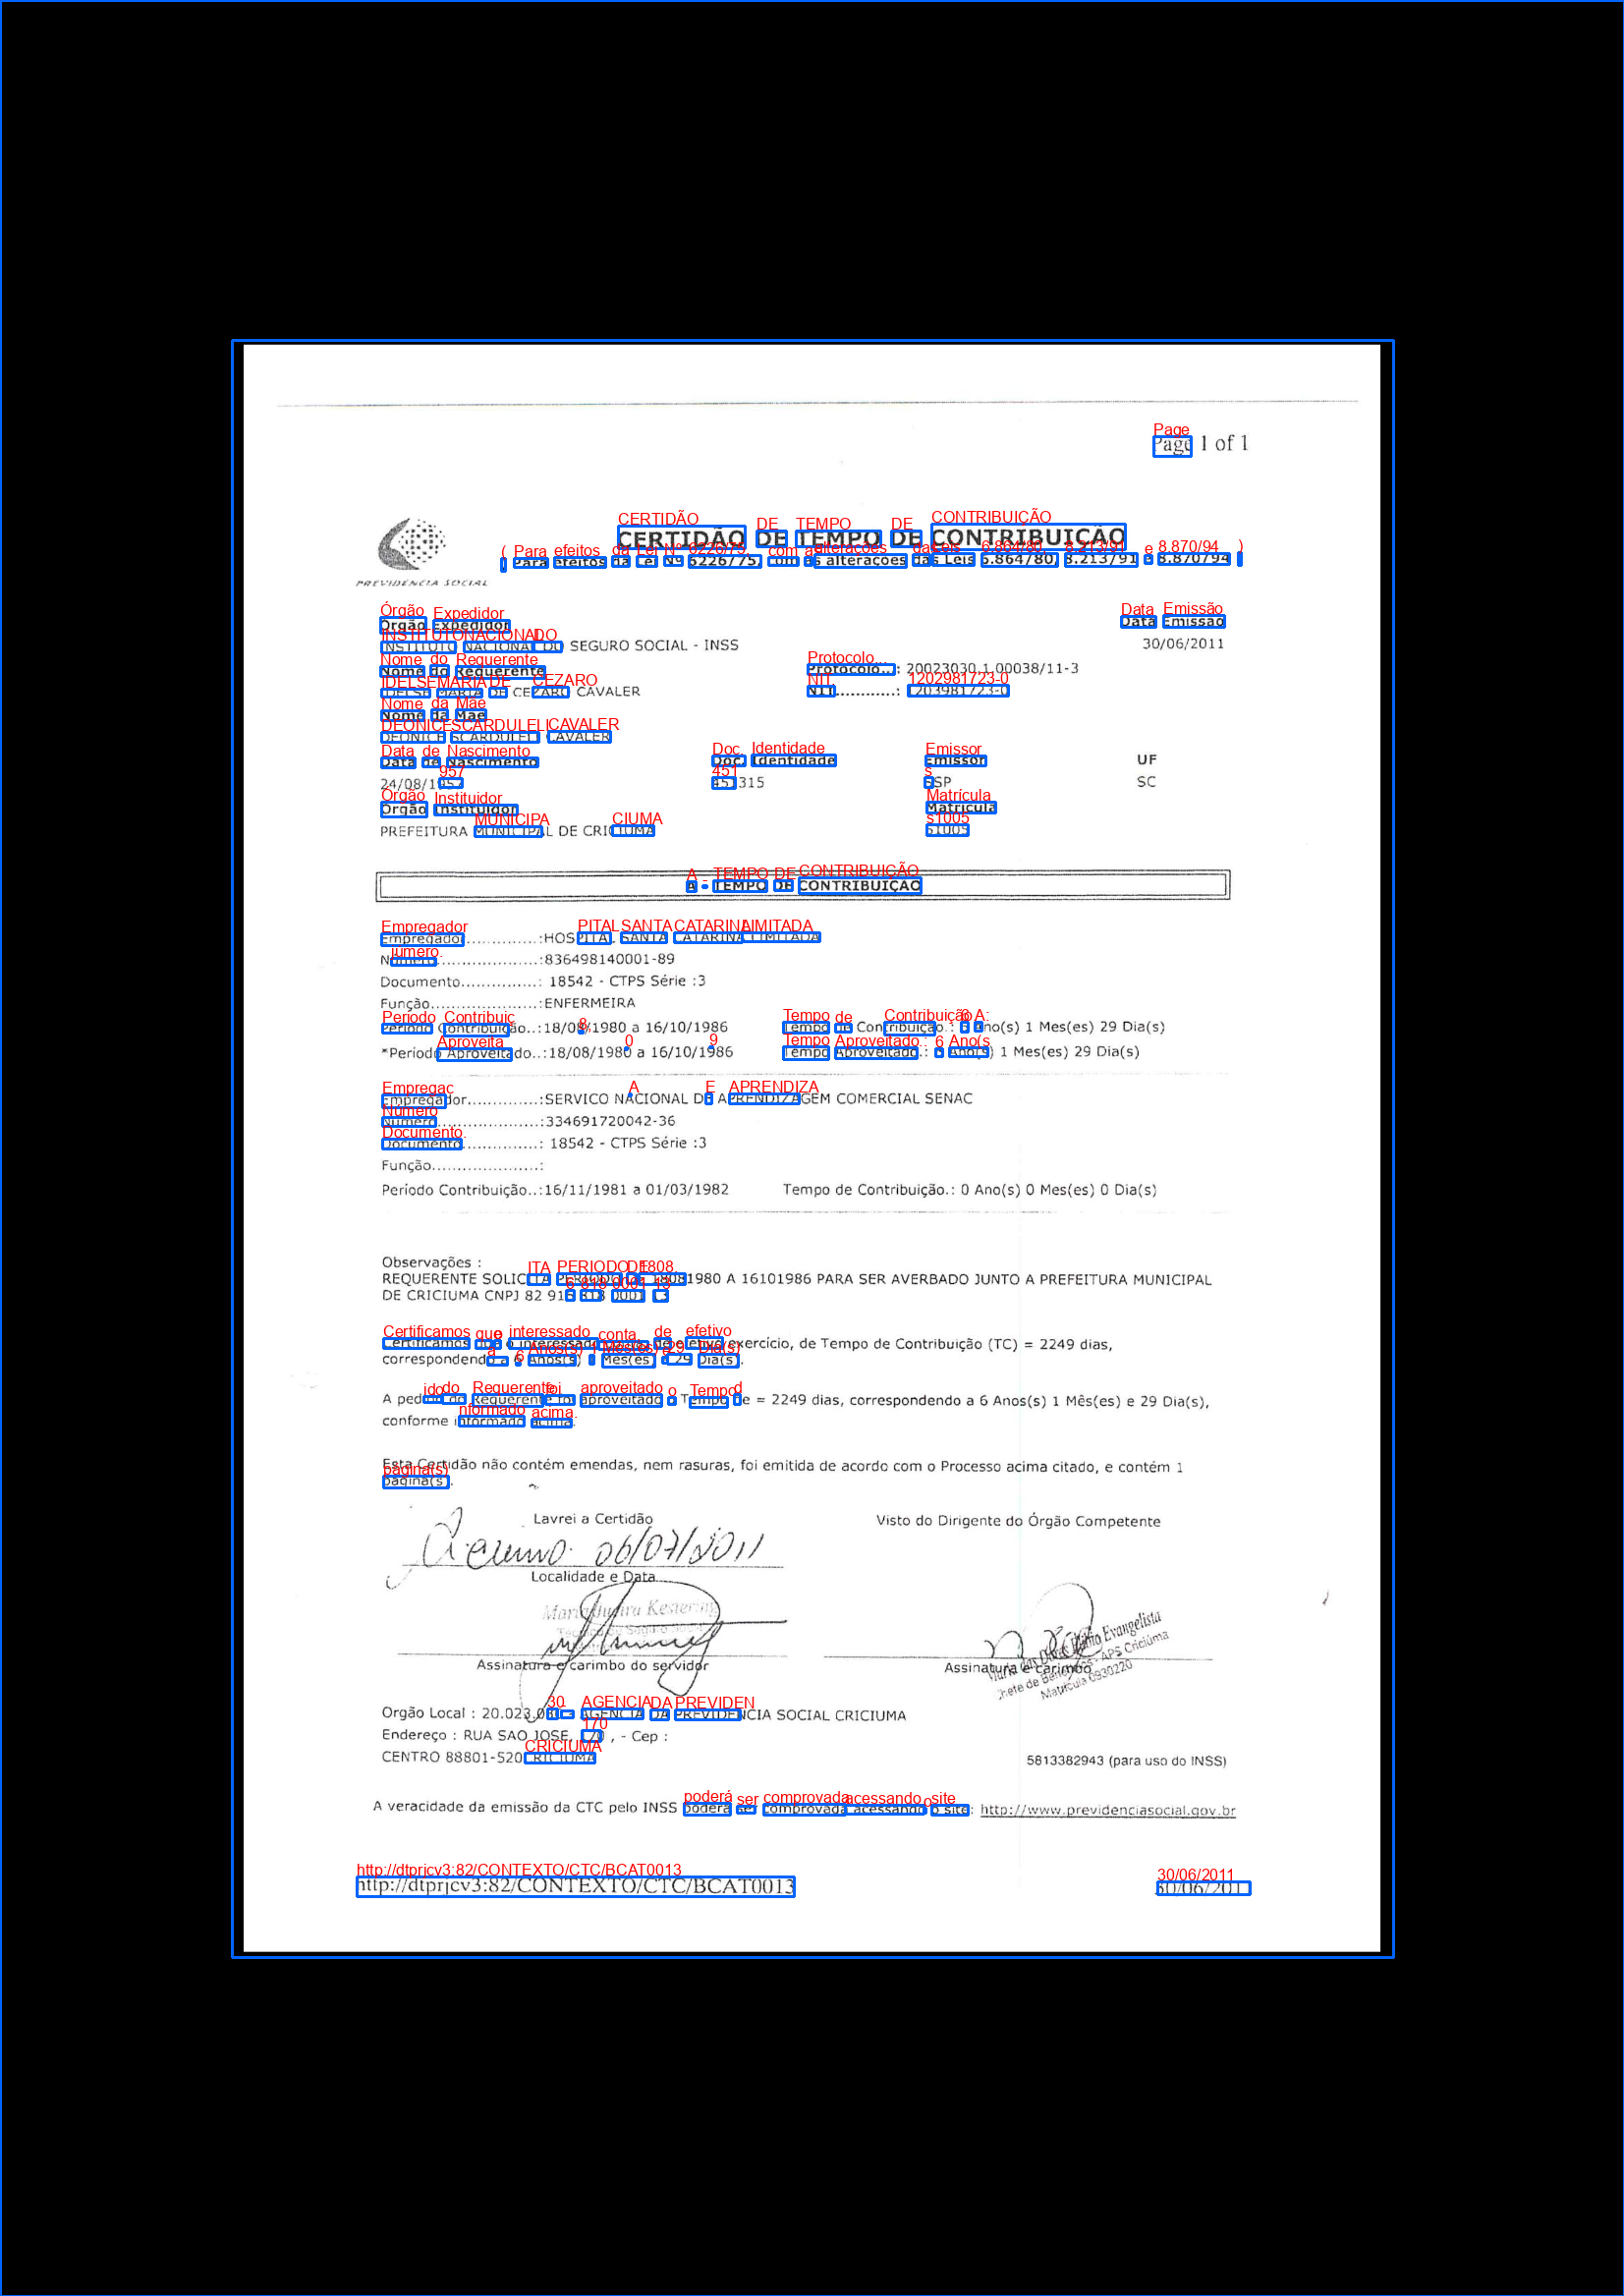

'Page CERTIDÃO DE TEMPO DE CONTRIBUIÇÃO ( Para efeitos da Lei Nº 6226/75, com as alterações das Leis 6.864/80, 8.213/91 e 8.870/94 ) Órgão Expedidor Data Emissão INSTITUTO NACIONAL DO Nome do Requerente Protocolo... IDELSE MARIA DE CEZARO NIT. 1202981723-0 Nome da Mãe DEONICE SCARDULELI CAVALER Data de Nascimento Doc. Identidade Emissor 957 451 s Órgão Instituidor Matrícula MUNICIPA CIUMA s1005 A - TEMPO DE CONTRIBUIÇÃO Empregador PITAL SANTA CATARINA LIMITADA júmero. Periodo Contribuiç 8, Tempo de Contribuição. : 6 A: Aproveita 0 9 Tempo Aproveitado.: 6 Ano(s Empregac A E APRENDIZA Número Documento. ITA PERIODO DE 1808. 6 818 0001 13 Certificamos que o interessado conta, de efetivo a 6 Anos(s) 1 Mês(es) e 29 Dia(s) ido do Requerente foi aproveitado o Tempo d nformado acima. página(s) 30 - AGENCIA DA PREVIDEN 170 CRICIUMA poderá ser comprovada acessando o site http://dtprjcv3:82/CONTEXTO/CTC/BCAT0013 30/06/2011  '

In [ ]:
img_copia1 = img1.copy()
full_text = ""

for i in range(0, len(result1['text'])):
  trust = int(result1['conf'][i])

  if trust > min_conf:
    x, y, img = text_box(result1, img_copia1)
    text = result1["text"][i]
    full_text += result1["text"][i] + " "
    #cv2.putText(img_copia1, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
    img_copia1 = write_text(text, x, y, img_copia1, font) 

cv2_imshow(img_copia1)
full_text

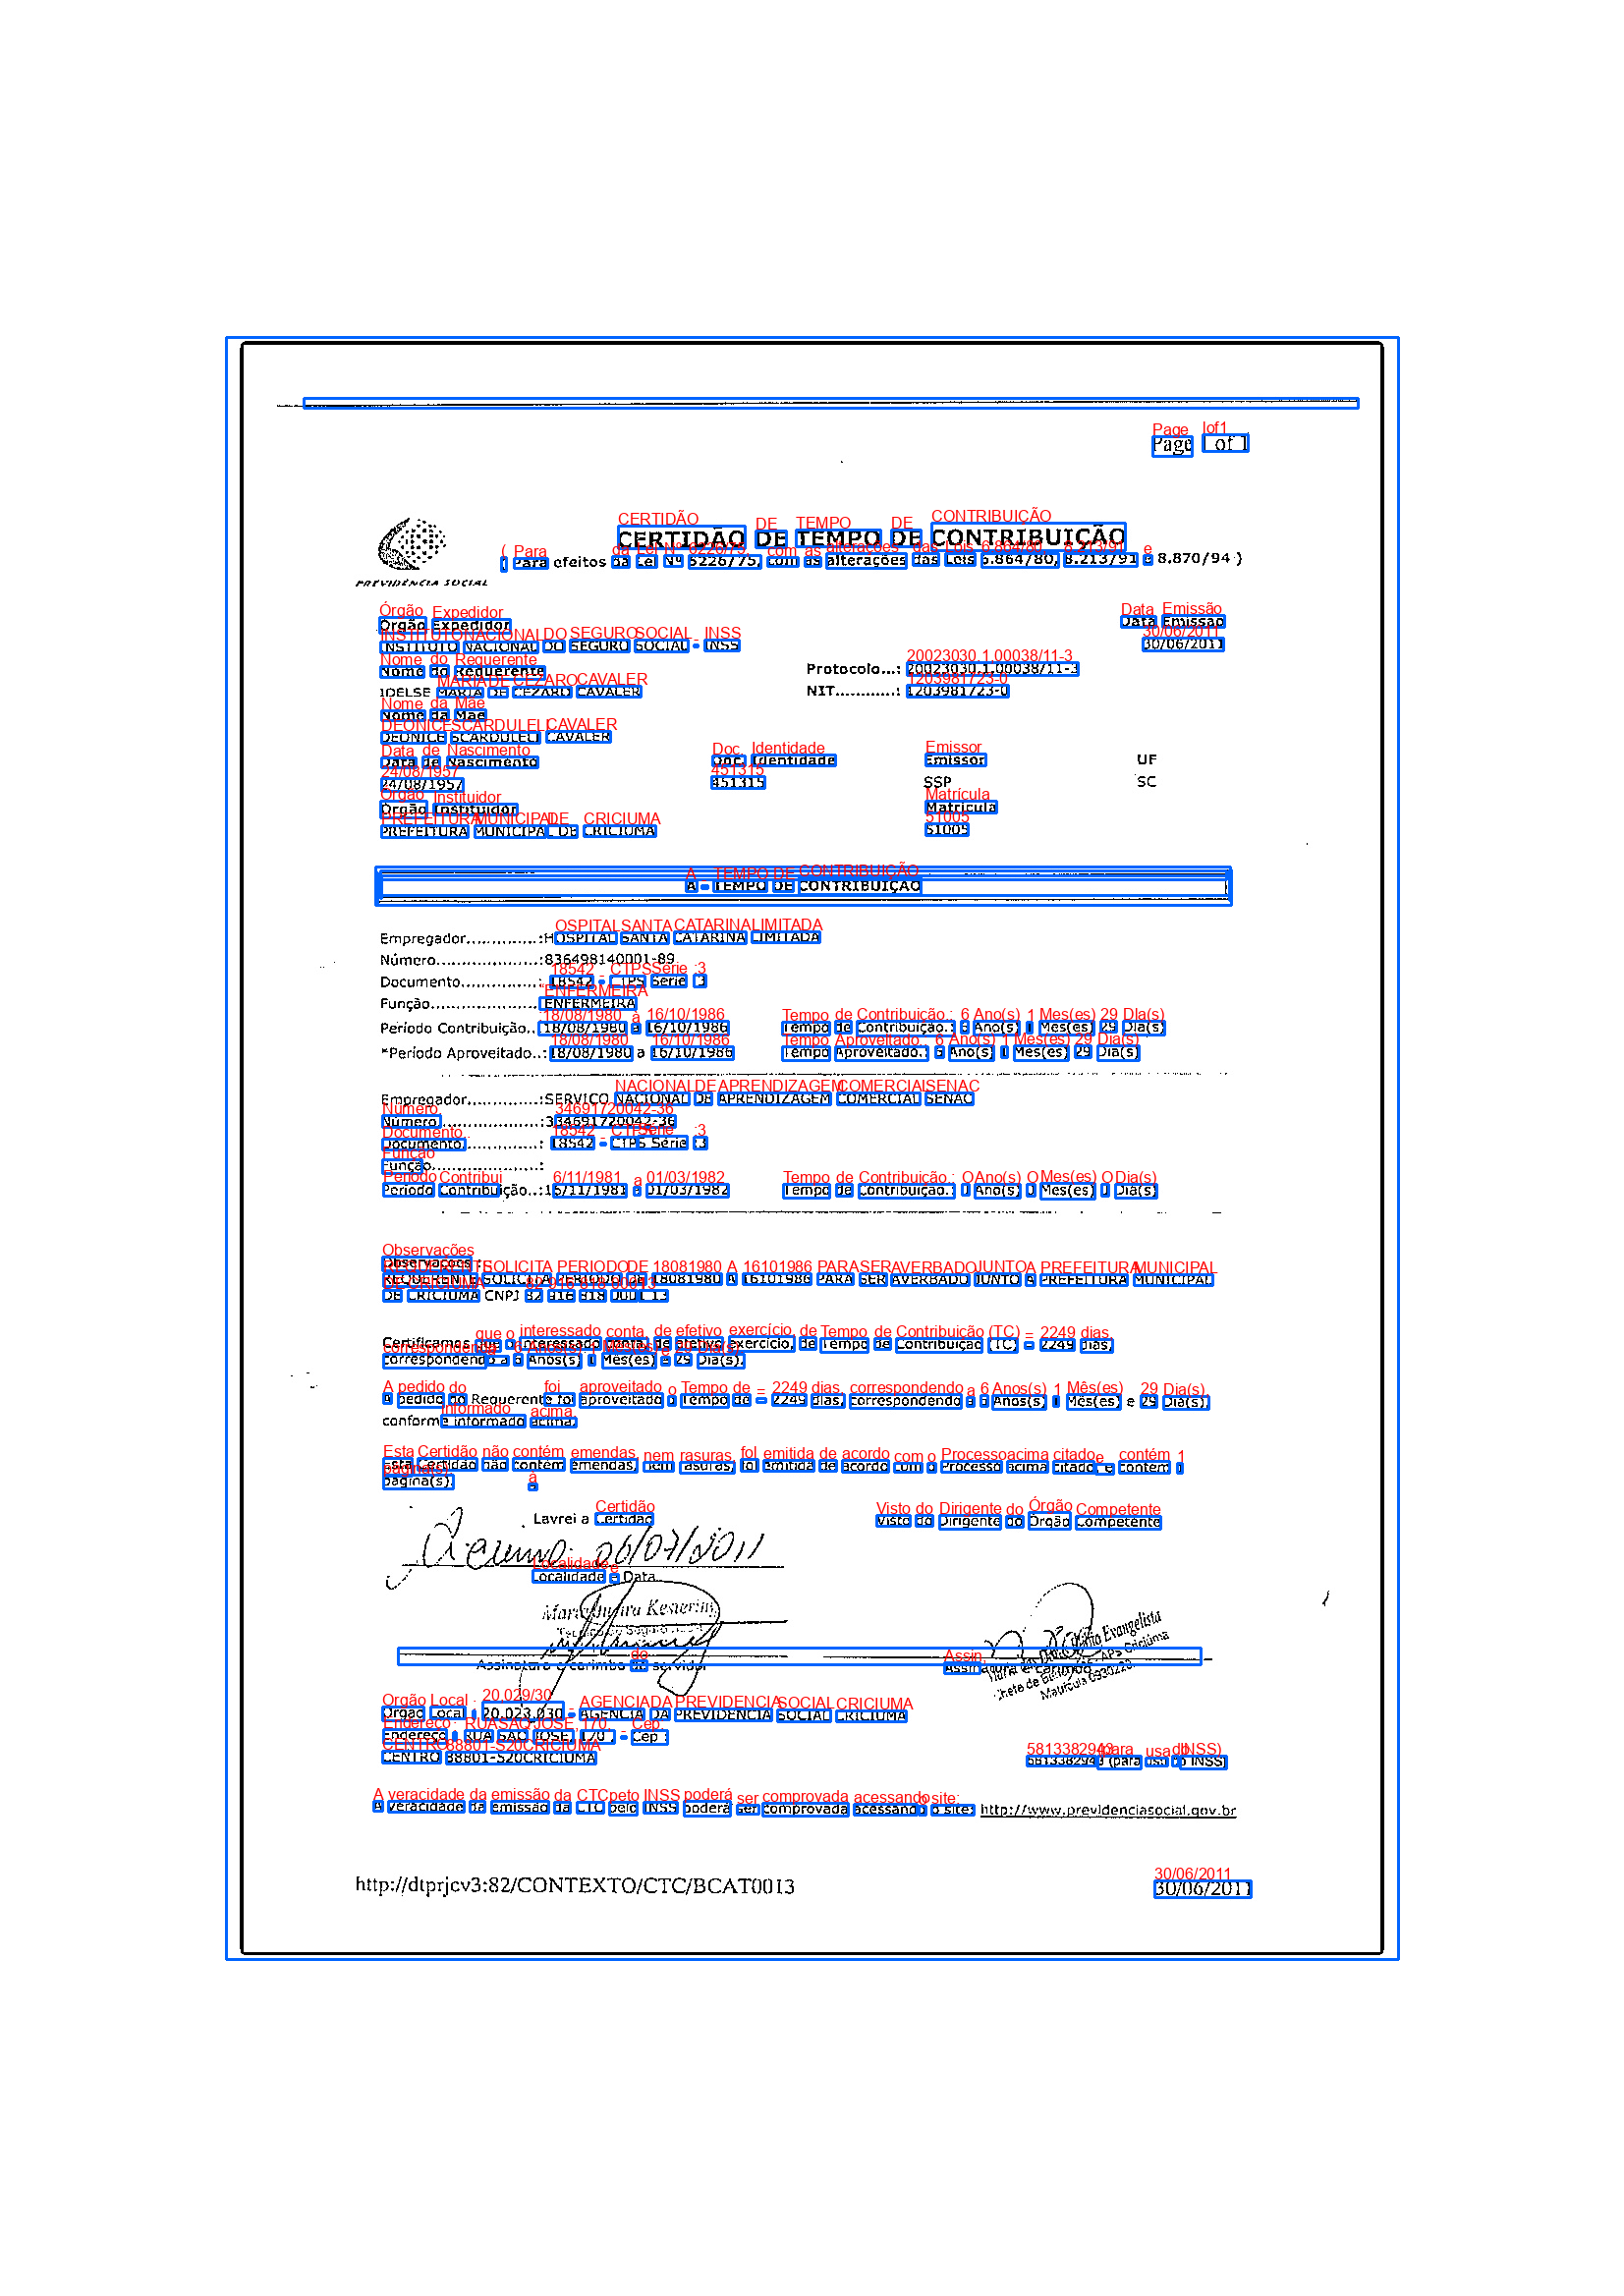

'  Page lof1 CERTIDÃO DE TEMPO DE CONTRIBUIÇÃO ( Para da Lel Nº 6226/75, com as alterações das Lois 6.864/80, 8.213/91 e Órgão Expedidor Data Emissão INSTITUTO NACIONAL DO SEGURO SOCIAL - INSS 30/06/2011 Nome do Requerente 20023030.1,00038/11-3 MARIA DE CEZARO CAVALER 1203981723-0 Nome da Mãe DEONICE SCARDULELI CAVALER Data de Nascimento Doc. Identidade Emissor 24/08/1957 451315 Órgão Instituidor Matrícula PREFEITURA MUNICIPAL DE CRICIUMA 51005       A - TEMPO DE CONTRIBUIÇÃO       OSPITAL SANTA CATARINA LIMITADA 18542 - CTPS Série :3 “ENFERMEIRA :18/08/1980 à 16/10/1986 Tempo de Contribuição.: 6 Ano(s) 1 Mes(es) 29 Dla(s) 18/08/1980 16/10/1986 Tempo Aproveltado.: 6 Ano(s) 1 Mes(es) 29 Dia(s) NACIONAL DE APRENDIZAGEM COMERCIAL SENAC Número. 34691720042-36 Documento.. 18542 - CTPS Série :3 Função Periodo Contribui 6/11/1981 a 01/03/1982 Tempo de Contribuição.: O Ano(s) O Mes(es) O Dia(s) Observações REQUERENTE SOLICITA PERIODO DE 18081980 A 16101986 PARA SER AVERBADO JUNTO A PREFEITURA 

In [ ]:
img_copia2 = img2.copy()
full_text = ""

for i in range(0, len(result2['text'])):
  trust = int(result2['conf'][i])
  if trust > min_conf:
    x, y, img = text_box(result2, img_copia2)
    text = result2["text"][i]
    full_text += result2["text"][i] + " "
    #cv2.putText(img_copia2, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255))
    img_copia2 = write_text(text, x, y, img_copia2, font) 
    
cv2_imshow(img_copia2)
full_text